In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Download, read in, preprocess data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [6]:
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [7]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]

There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [8]:
precip_outliers = np.where(regions_precip > 100)[0]

In [9]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)

In [10]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [11]:
labels = labels.drop(drop_idx)

In [12]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [13]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

**Why do we want to do feed in weather data to a neural network when other data is available?** This is a good question. Generally, we cannot send people everywhere to inspect avalanche conditions. That means that there are many places where the *only* data that we have available comes in the form of weather forecasts and observations. Thus, it is important to see if a model can predict danger level or the first avalanche problem given only weather data.

In [14]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    #df.drop(col_list, axis=1, inplace=True)
    return df

In [15]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [16]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [17]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [18]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
all_wx_cols = [col for col in regions.columns]

for drop_col in dont_include_list:
    all_wx_cols = [col for col in all_wx_cols if drop_col not in col]

#all_wx_cols

In [19]:
train = regions.loc[:, all_wx_cols]

In [20]:
train.loc[:, 'danger_level_1']

region  date      
3003    2017-12-07    1.0
3007    2017-12-07    3.0
3009    2017-12-07    3.0
3010    2017-12-07    3.0
3011    2017-12-07    3.0
                     ... 
3031    2021-01-12    3.0
3032    2021-01-12    3.0
3034    2021-01-12    3.0
3035    2021-01-12    3.0
3037    2021-01-12    3.0
Name: danger_level_1, Length: 12519, dtype: float64

In [21]:
danger_cols = [col for col in train.columns if 'danger' in col]

for col in danger_cols:
    train.loc[:, col][train.loc[:, col].values == 1] = 0
    train.loc[:, col][train.loc[:, col].values == 2] = 0
    train.loc[:, col][train.loc[:, col].values == 3] = 0
    train.loc[:, col][train.loc[:, col].values == 4] = 1

In [22]:
np.unique(train[danger_cols])

array([0., 1.])

In [23]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X)
    return scaled

In [24]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)

In [25]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]

In [26]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
1                     18.82
2                     52.81
3                     26.48
4                      1.89
dtype: float64

So we see that there is a heavy imbalance in the class weights that we are trying to predict. This is not ideal for our case, because more than anything we need to reliably be able to predict danger levels 3 and 4. Scikit-learn makes this easy to do for imbalanced classification tasks.

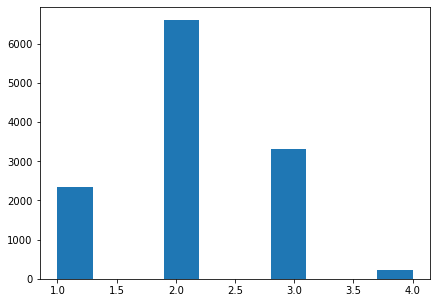

In [27]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels, align='mid', )#rwidth=0.85)
plt.show()

### Outlier Detection

Since the classes are so imbalanced, we could treat this like an outlier detection problem and only try to detect avalanche danger level 4's.

In [28]:
train_labels[train_labels.values == 1] = 0
train_labels[train_labels.values == 2] = 0
train_labels[train_labels.values == 3] = 0
train_labels[train_labels.values == 4] = 1

print(np.unique(train_labels.values))

[0 1]


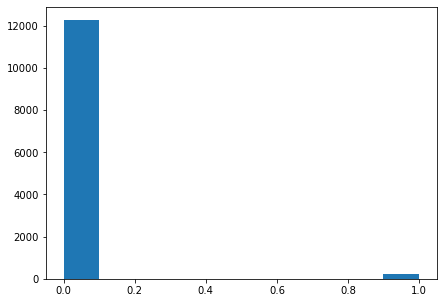

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values)
plt.show()

In [30]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
0                     98.11
1                      1.89
dtype: float64

We can set some class weights below so that the model we train prioritizes getting danger level 4's correct. Note: this can act as another form of regularization for the model.

The weights are set to be about equal to what you would get with the [`compute_class_weight()`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) method in Scikit-Learn.

In [31]:
weights = {
    0: 0.5,
    1: 25
}

weights

{0: 0.5, 1: 25}

# Split data

In [32]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [33]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

In [34]:
sequence_length = 7 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [35]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(8933, 1335)
(8933, 1)
(1722, 1335)
(1722, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [36]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()

In [37]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [38]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(8926, 7, 1335) (8926, 2)
(1715, 7, 1335) (1715, 2)


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [39]:
def create_dnn(X, n_input, dropout, n_output, add_reg=False):
    """
    Create a DNN with or without regularization. Note: X should have
    shape (samples, timesteps, features)
    """
    timesteps = X.shape[1]
    features = X.shape[2]
    
    # design network
    dnn = tf.keras.models.Sequential()
    if(add_reg == True):
        reg = tf.keras.regularizers.l2(l=0.0001)
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg, input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg))
        dnn.add(Dropout(dropout))
        
        dnn.add(Dense(n_input, activation='elu', kernel_regularizer=reg))
        
    else:
        dnn.add(Dense(n_input, activation='elu', input_shape=(timesteps, features)))
        dnn.add(Dropout(dropout))
        
        dnn.add(Dense(n_input, activation='elu'))
        dnn.add(Dropout(dropout))
        
        dnn.add(Dense(n_input, activation='elu'))
    
    dnn.add(Dropout(dropout))
    dnn.add(tf.keras.layers.Flatten())
    dnn.add(Dense(n_output, activation='sigmoid'))
    
    return dnn

In [40]:
def train(model, X, y, X_val, y_val, loss, opt, batch, e, w):
    """
    Train a neural network with passed in hyperparameters.
    """
    # compile and fit model
    model.compile(loss=loss, 
                  optimizer=opt, 
                  metrics=['Recall'])

    history = model.fit(X, y, validation_data=(X_val, y_val),
                        batch_size=batch, epochs=e, verbose=0, 
                        shuffle=False, class_weight=w)
    
    return history

In [41]:
def plot_history(history):
    """
    Plot the loss function vs epochs and metric vs epochs after
    training a neural network.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # plot loss over time
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='val')
    
    # plot metric over time
    ax[1].plot(history.history['recall'], label='train')
    ax[1].plot(history.history['val_recall'], label='val')
    
    ax[0].set_title('Loss')
    ax[1].set_title('recall')
    
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [42]:
def plot_confusion_matrix(model, X, y_true):
    y_pred = np.argmax(model.predict(X), axis=1)
    precision, recall, fscore, support = score(y_true, y_pred)
    print('precision: {}'.format(precision))
    print('recall:    {}'.format(recall))
    print('fscore:    {}'.format(fscore))

    #use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

    #set x and y labels, as well as title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('ROC Confusion Matrix')

    plt.show()
    
    return y_pred

In [43]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 1200
alpha = 1e-4
batch_size = len(batchX_train)
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [44]:
print(batch_size)

8926


In [45]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train(window_dnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


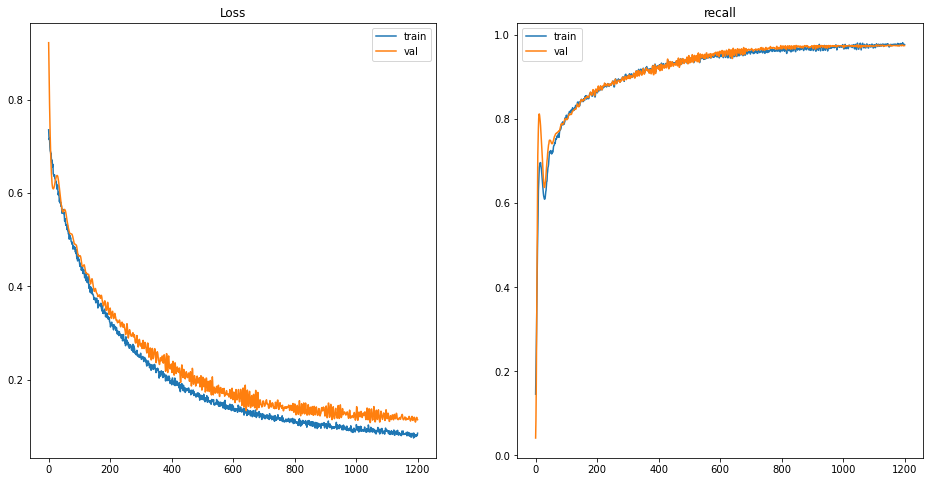

In [46]:
plot_history(window_dnn_reg_history)

precision: [0.99516616 0.41666667]
recall:    [0.97919144 0.75757576]
fscore:    [0.98711417 0.53763441]


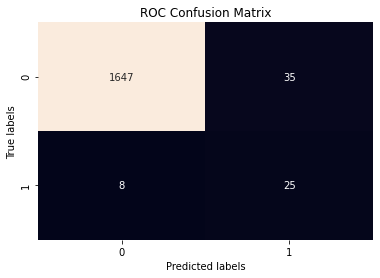

In [47]:
preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

This is looking fairly good, but, ideally that bottom left square would be 0 (no false negatives). We can play with the sensitivity to try and get that square to 0, and then use the same threshold value for the test set. I am interested in doing this because I believe there are many instances where the danger level is 4, but the model is not able to distinguish it from a danger level of 3.

In plain text, this strategy would be something like:
> "We care most about predicting a danger level 4 when it is a danger level 4, and less about over-predicting danger level 4's."

So ideally, we would have a precision greater than 50% and a recall score as close to 100% as possible. **It might be worth looking at why the Keras recall score says 95+% on the validation set while the scikit-learn version gets only 78%.**

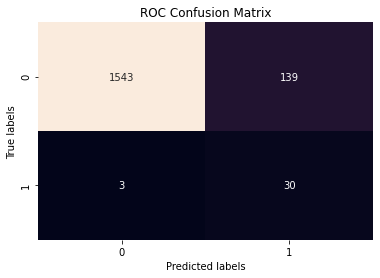

In [48]:
probs = window_dnn_reg.predict(batchX_val)
to_save = []
for proba_pair in probs:
    if(proba_pair[1] > 0.05):
        to_save.append(1)
    else: 
        to_save.append(0)

#use seaborn's sns.heatmap() function for pretty plotting of confusion matrix
cm = confusion_matrix(np.argmax(batchY_val, axis=1), to_save)
ax = sns.heatmap(cm, annot=True, fmt='d', cbar=False)

#set x and y labels, as well as title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('ROC Confusion Matrix')

plt.show()

When we do this, we can limit the number of false negatives, but at the cost of predicting danger level 4 *much* more often. This makes me a little uncomfortable, because I don't want to over-optimize for the validation set and have it not generalize to the test set.

Maybe we should use some sort of early stopping?
- - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Or perhaps we could save the model each time we improve on recall?

In [49]:
# recall
greater_than = np.where(np.array(window_dnn_reg_history.history['val_recall']) > 0.99)[0]
for val in greater_than:
    print('Recall:', window_dnn_reg_history.history['val_recall'][val])
    
# loss
less_than = np.where(np.array(window_dnn_reg_history.history['val_loss']) < 0.05)[0] #it never reaches that low
for val in less_than:
    print('Loss:', window_dnn_reg_history.history['val_loss'][val])

# Summary so far:
- batching data works better than non-batching, although after trying several values for the window size, most perform the same
- regularization definitely helps
- DNNs perform the best overall, RNNs perform okay when only using the RegObs data
- using both regobs and varsom data improves performance
- class weights work well
- classifying danger level 4 as an outlier works better than trying to classify danger levels 1-4
- I am no longer optimizing for accuracy, only loss and recall
- I am not sure of the effect of shuffling when using DNNs. Performance seems comparable.
- 2 vs 3 layer DNNs perform similarly, although I received my best results so far with a 2 layer DNN. This might be worth looking at in hyperopt.

I believe that I am reaching unreducible error in the validation set. I believe that there are some danger level 4's that look like 3's, and have never reached lower than 3 false negatives after training (and before playing with the prediction sensitivity). I think I have found a batch size, learning rate, epoch number, regularization parameter, and several other optimal hyperparameters, so it may be time to predict on the test set after running a bunch of models and saving the best one. I need to find a way to do this with the recall metric.